In [23]:
%matplotlib inline

import numpy as np
import pylab as pl
from pymc3 import Model, Normal, HalfNormal, ADVI
import pymc3 as pm
import matplotlib.pyplot as plt


(array([  3.,   4.,   2.,  13.,  12.,  23.,  31.,  44.,  56.,  58.,  50.,
         51.,  41.,  36.,  33.,  18.,  14.,   4.,   5.,   2.]),
 array([ 2.17913127,  2.46400446,  2.74887764,  3.03375083,  3.31862402,
         3.60349721,  3.88837039,  4.17324358,  4.45811677,  4.74298996,
         5.02786314,  5.31273633,  5.59760952,  5.88248271,  6.1673559 ,
         6.45222908,  6.73710227,  7.02197546,  7.30684865,  7.59172183,
         7.87659502]),
 <a list of 20 Patch objects>)

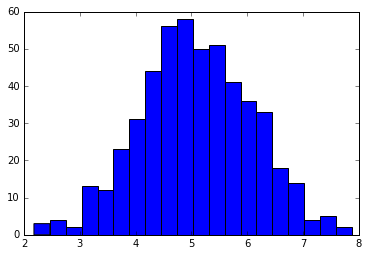

In [24]:
# Generate sample data
N = 500
mu_true = 5.0
sigma_true = 1.0
X = np.random.normal(loc=mu_true, scale=sigma_true, size=N).astype(np.float32)
plt.hist(X, bins=20)

In [25]:
model = Model()
with model:
    # Prior
    mu_0 = 1.0
    sigma_0 = 1.0
    mu = Normal("mu", mu=mu_0, sd=sigma_0)
    #sigma = HalfNormal("sigma")
    
    # Data
    X_obs = Normal("X_obs", mu=mu, sd=sigma_true, observed=X)

    # Fit
    #mean_field = pm.fit(method='advi')
    
    

In [26]:
#pm.plot_posterior(mean_field.sample(1000), color='LightSeaGreen')

In [27]:
with model:
    advi = pm.ADVI()
advi.approx
advi.approx.shared_params

advi.approx.mean.eval(), advi.approx.std.eval()
tracker = pm.callbacks.Tracker(
    mean=advi.approx.mean.eval,  # callable that returns mean
    std=advi.approx.std.eval  # callable that returns std
)
approx = advi.fit(20000, callbacks=[tracker])

Average Loss = 722.6: 100%|██████████| 20000/20000 [00:09<00:00, 2040.48it/s]


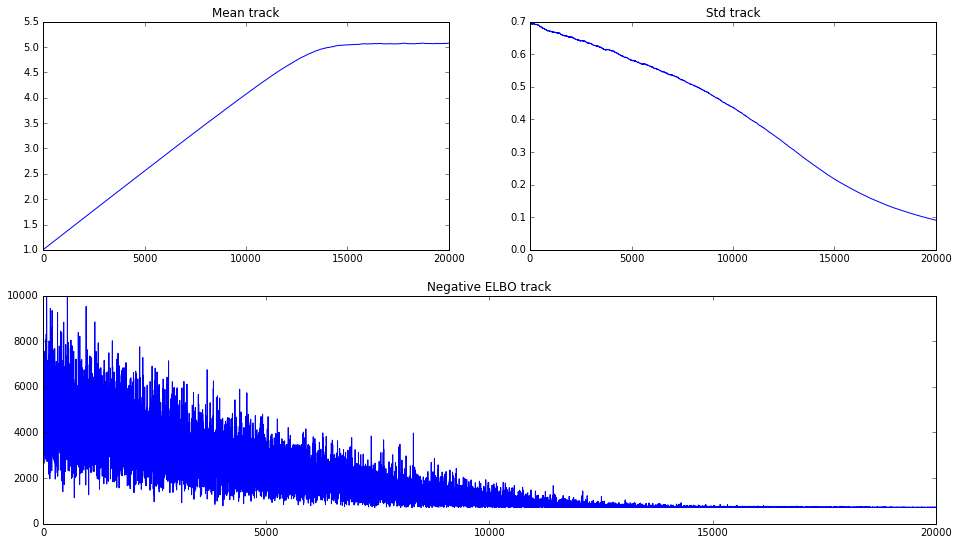

In [28]:
fig = plt.figure(figsize=(16, 9))
mu_ax = fig.add_subplot(221)
std_ax = fig.add_subplot(222)
hist_ax = fig.add_subplot(212)
mu_ax.plot(tracker['mean'])
mu_ax.set_title('Mean track')
std_ax.plot(tracker['std'])
std_ax.set_title('Std track')
hist_ax.plot(advi.hist)
hist_ax.set_title('Negative ELBO track');

In [29]:
advi.refine(100000)

Average Loss = 721.52: 100%|██████████| 100000/100000 [00:48<00:00, 2082.57it/s]


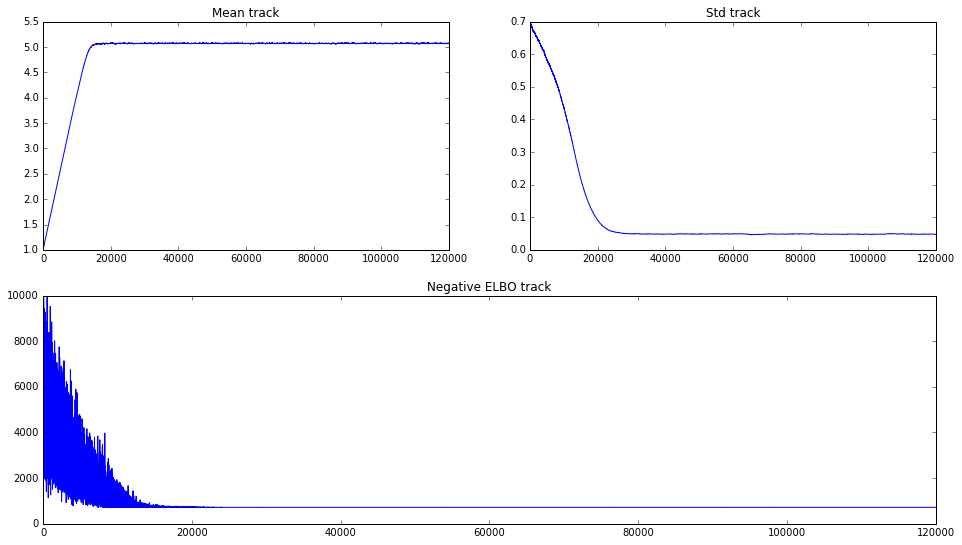

In [38]:
fig = plt.figure(figsize=(16, 9))
mu_ax = fig.add_subplot(221)
std_ax = fig.add_subplot(222)
hist_ax = fig.add_subplot(212)
mu_ax.plot(tracker['mean'])
mu_ax.set_title('Mean track')
std_ax.plot(tracker['std'])
std_ax.set_title('Std track')
hist_ax.plot(advi.hist)
hist_ax.set_title('Negative ELBO track');


[ 5.06665122] [ 0.04765369]


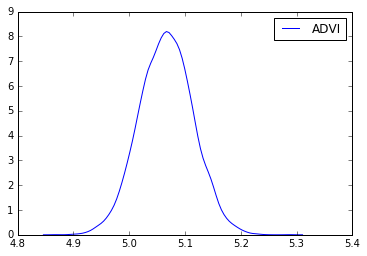

In [41]:
# Posterior plot
import seaborn as sns
#ax = sns.kdeplot(trace['x'], label='NUTS');
sns.kdeplot(approx.sample(10000)['mu'], label='ADVI');

# final posterior std and mean
print tracker['mean'][-1], tracker["std"][-1]

In [43]:
# Posterior for gaussian with known scale is known
# See: https://www.cs.ubc.ca/~murphyk/Papers/bayesGauss.pdf
prec = 1.0 / (sigma_true**2)
prec_0 = 1.0 / (sigma_0**2)
mu_MLE = np.mean(X)
prec_N = prec_0 + N * prec
w = N * prec / prec_N
mu_N = w * mu_MLE + (1.0 - w) * mu_0
scale_N = np.sqrt(1. / prec_N)
print mu_N, scale_N

5.06983369839 0.0446767051609


In [50]:
with model:
    sgvd = pm.SVGD() 
    tracker = pm.callbacks.Tracker(
        mean=advi.approx.mean.eval,  # callable that returns mean
        std=advi.approx.std.eval  # callable that returns std
    )
    svgd_approx = sgvd.fit(300, n_particles=1000,
                           obj_optimizer=pm.sgd(learning_rate=0.01), callbacks=[tracker])


TypeError: step_function() got an unexpected keyword argument 'n_particles'

[ 5.06665122] [ 0.04765369]


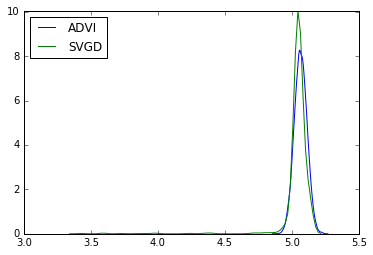

In [47]:
#ax = sns.kdeplot(trace['mu'], label='NUTS');
sns.kdeplot(approx.sample(10000)['mu'], label='ADVI');
sns.kdeplot(svgd_approx.sample(2000)['mu'], label='SVGD');

# final posterior std and mean
print tracker['mean'][-1], tracker["std"][-1]